# Get data for ML4P PS3

## Author:
- **David W. Hogg** (NYU)

## License:
This code is public domain. Copy it to begin your Problem Set 3.

## Comments:
- This code just gets one chunk of the APOGEE data; feel free to modify for your purposes.

## Bugs / issues:
- The way `astropy.io` works is that it downloads files the first time you read them, and then the *next* time you read them it reads them from cache. So this code is slow on first running but gets faster on repeats.

In [1]:
import numpy as np
from astropy.io import fits
import pylab as plt # only needed for verification

In [2]:
# construct url to the file of labels and read it
base_url = "https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/"
fn = "allStarLite-dr17-synspec_rev1.fits"
allstar = fits.open(base_url + fn)
for a in allstar:
    print(a)

(5.0, 0.0)

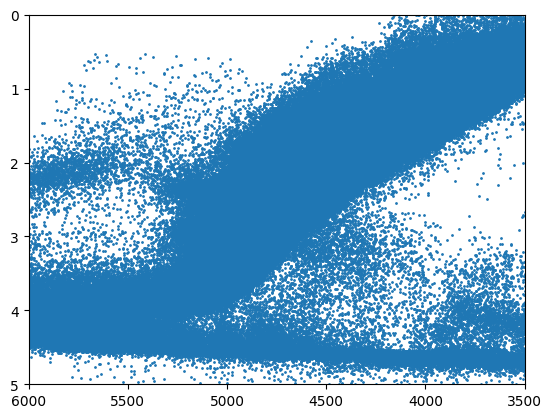

In [3]:
# the labels are in an enormous table in element [1] of this FITS file
labels = allstar[1].data
plt.scatter(labels['TEFF'], labels['LOGG'], s=1)
plt.xlim(6000, 3500)
plt.ylim(5, 0)

In [4]:
# make a reasonable red-giant-branch sample
RGB = True
RGB = np.logical_and(RGB, labels['TEFF'] > 3500.)
RGB = np.logical_and(RGB, labels['TEFF'] < 5400.)
RGB = np.logical_and(RGB, labels['LOGG'] < 3.0)
RGB = np.logical_and(RGB, labels['LOGG'] > 0.0)
RGB = np.logical_and(RGB, labels['H'] < 10.5)
print(np.sum(RGB))

145991


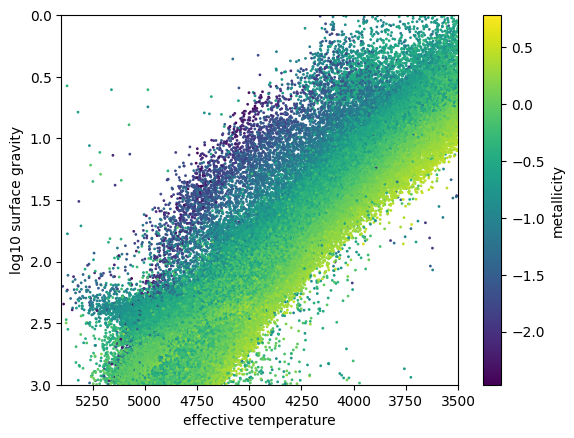

In [5]:
# make a plot that an astronomer likes to see
RGB_labels = labels[RGB]
plt.scatter(RGB_labels['TEFF'], RGB_labels['LOGG'], c=RGB_labels['FE_H'], s=1)
plt.xlim(5400, 3500)
plt.xlabel("effective temperature")
plt.ylim(3., 0.)
plt.ylabel("log10 surface gravity")
plt.colorbar(label="metallicity")

In [6]:
# make train, validation, and test data sets
rng = np.random.default_rng(17)
N_RGB = len(RGB_labels)
N_train, N_valid, N_test = 1024, 256, 512
I = rng.permutation(N_RGB)
I_train = I[0:N_train]
I_valid = I[N_train:N_train+N_valid]
I_test = I[N_train+N_valid:N_train+N_valid+N_test]
train_labels = RGB_labels[I_train]
valid_labels = RGB_labels[I_valid]
test_labels = RGB_labels[I_test]
print(len(train_labels), len(valid_labels), len(test_labels))

1024 256 512


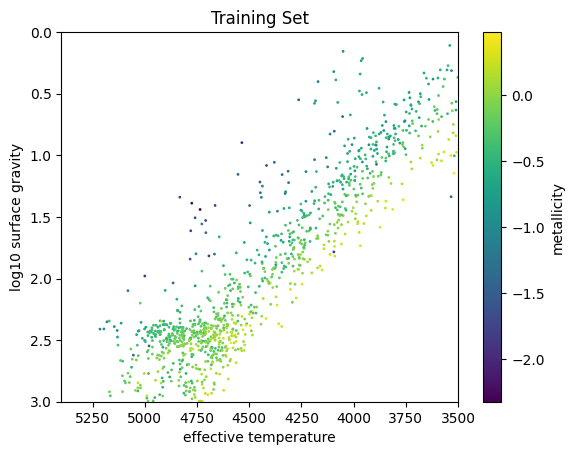

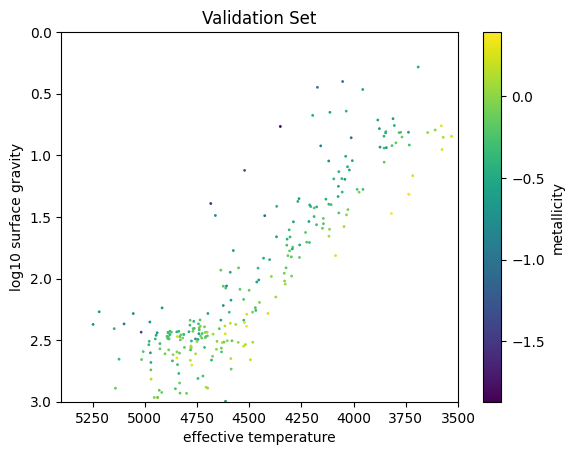

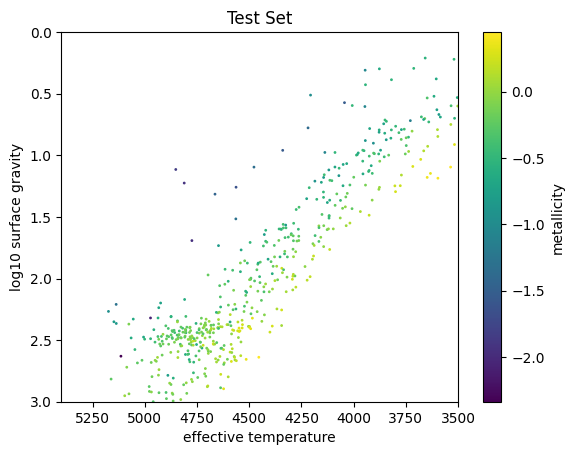

In [7]:
# Plot the labels of the three data sets
# make a plot that an astronomer likes to see
for l, t in [(train_labels, "Training Set"),
             (valid_labels, "Validation Set"),
             (test_labels, "Test Set")]:
    plt.figure()
    plt.title(t)
    plt.scatter(l['TEFF'], l['LOGG'], c=l['FE_H'], s=1)
    plt.xlim(5400, 3500)
    plt.xlabel("effective temperature")
    plt.ylim(3., 0.)
    plt.ylabel("log10 surface gravity")
    plt.colorbar(label="metallicity")

In [8]:
# now time to read the spectral data - the features - this HURTS
def get_features(labels):
    features = None
    for l in labels:
        url = base_url + l['TELESCOPE'] + "/" + l['FIELD'] + "/aspcapStar-dr17-" + l['APOGEE_ID'] + ".fits"
        x = fits.open(url)[1].data
        if features is None:
            features = x[None, :]
        else:
            features = np.concatenate((features, x[None, :]), axis=0)
    return features

In [9]:
# This will take a while, the first time you run it. Don't be alarmed.
train_features = get_features(train_labels)
valid_features = get_features(valid_labels)
test_features = get_features(test_labels)
print(train_features.shape, valid_features.shape, test_features.shape)

(1024, 8575) (256, 8575) (512, 8575)


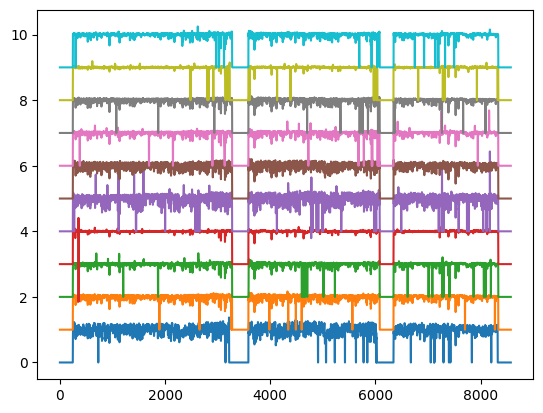

In [10]:
for i in range(10):
    plt.plot(train_features[i] + i)

In [19]:
# save the data to disk
# (modifications by connor)

from os import makedirs
makedirs('hw3_data', exist_ok=True)

# save labels as cloudpickles
import cloudpickle
with open('hw3_data/train_labels.pkl', 'wb') as f:
    cloudpickle.dump(train_labels, f)
with open('hw3_data/val_labels.pkl', 'wb') as f:
    cloudpickle.dump(valid_labels, f)
with open('hw3_data/test_labels.pkl', 'wb') as f:
    cloudpickle.dump(test_labels, f)

# save features as .npy files
np.save('hw3_data/train_features.npy', train_features)
np.save('hw3_data/val_features.npy', valid_features)
np.save('hw3_data/test_features.npy', test_features)